# <u>**Streaming Service Comparison**</u>

### **Objective:**
- Determine which streaming platform hosts the majority of content I enjoy so that I can pare down the services to which I subscribe. 

### **Data Sources:**
- [Netflix via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-netflix-dataset)
- [Hulu via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-hulu-dataset)
- [Prime via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-amazon-prime-dataset/data)
- [AppleTV via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-apple-tv-dataset)

## **Data Collection & Loading**

### **Import Pandas, Numpy, Matplotlib, Wordcloud, and PIL**

In [28]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

### **Data Load**

In [2]:
# Load in each file separately. 
apple = pd.read_csv("Data/AppleTV.csv")
hulu = pd.read_csv("Data/Hulu.csv")
netflix = pd.read_csv("Data/Netflix.csv")
prime = pd.read_csv("Data/Prime.csv")

### **Preliminary Review**

In [3]:
# View the head of each dataframe 

# Create a variable to include a list of all dataframes recently imported
dataframes = [apple, hulu, netflix, prime]
# Display only the head of each dataframe separately
for df in dataframes:
    display(df.head())

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN
1,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
2,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN
3,Citizen Kane,movie,"Drama, Mystery",1941.0,tt0033467,8.3,478085.0,NaN
4,Metropolis,movie,"Drama, Sci-Fi",1927.0,tt0017136,8.3,192628.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.5,7792.0,NaN
2,Finding Nemo,movie,"Adventure, Animation, Comedy",2003.0,tt0266543,8.2,1149529.0,NaN
3,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
4,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN
1,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN
2,Kill Bill: Vol. 1,movie,"Action, Crime, Thriller",2003.0,tt0266697,8.2,1238778.0,NaN
3,Jarhead,movie,"Biography, Drama, War",2005.0,tt0418763,7.0,214024.0,NaN
4,Unforgiven,movie,"Drama, Western",1992.0,tt0105695,8.2,449594.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN
1,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN
2,Judgment Night,movie,"Action, Crime, Drama",1993.0,tt0107286,6.6,19686.0,NaN
3,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
4,Citizen Kane,movie,"Drama, Mystery",1941.0,tt0033467,8.3,478085.0,NaN


In [4]:
# Using the same variable from above, dispaly the info for each dataframe to confirm column names and data types
for dframe in dataframes:
    display(dframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18281 entries, 0 to 18280
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               17700 non-null  object 
 1   type                18281 non-null  object 
 2   genres              17607 non-null  object 
 3   releaseYear         18249 non-null  float64
 4   imdbId              16775 non-null  object 
 5   imdbAverageRating   16363 non-null  float64
 6   imdbNumVotes        16363 non-null  float64
 7   availableCountries  82 non-null     object 
dtypes: float64(3), object(5)
memory usage: 1.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10259 entries, 0 to 10258
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               9610 non-null   object 
 1   type                10259 non-null  object 
 2   genres              9911 non-null   object 
 3   releaseYear         10221 non-null  float64
 4   imdbId              9193 non-null   object 
 5   imdbAverageRating   8885 non-null   float64
 6   imdbNumVotes        8885 non-null   float64
 7   availableCountries  43 non-null     object 
dtypes: float64(3), object(5)
memory usage: 641.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20877 entries, 0 to 20876
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               20225 non-null  object 
 1   type                20877 non-null  object 
 2   genres              20528 non-null  object 
 3   releaseYear         20842 non-null  float64
 4   imdbId              19356 non-null  object 
 5   imdbAverageRating   19166 non-null  float64
 6   imdbNumVotes        19166 non-null  float64
 7   availableCountries  166 non-null    object 
dtypes: float64(3), object(5)
memory usage: 1.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70294 entries, 0 to 70293
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               68616 non-null  object 
 1   type                70294 non-null  object 
 2   genres              68180 non-null  object 
 3   releaseYear         70107 non-null  float64
 4   imdbId              63868 non-null  object 
 5   imdbAverageRating   61528 non-null  float64
 6   imdbNumVotes        61528 non-null  float64
 7   availableCountries  360 non-null    object 
dtypes: float64(3), object(5)
memory usage: 4.3+ MB


None

### **Initial Insights**
- Each dataframe contains the same column headings
- None of the dataframes contain a column for the source of the dataframe
- All numerical columns appear to be floats and don't need to be
    - Change ***releaseYear*** and ***imdbNumVotes*** to integers
- The majority of the titles displayed contain multiple genres in the ***genres*** column
- The ***imdbId*** columns appear to match 
    - *American Beauty* in the 1st and 3rd dataframe
    - *Forest Gump* in the 1st, 2nd and 4th dataframes
- Of all the rows displayed, none include ***availableCountries*** data
    - Further information proves that this data point is not prevelent throughout the four dataframes


### **Preliminary Data Manipulation**

In [5]:
# Add a column to each dataframe to identify the data source since individually they do not have an identifier. This is to ensure the data is discernable after the merge when duplicate content is present
apple["Service_Name"] = "AppleTV"
hulu["Service_Name"] = "Hulu"
netflix["Service_Name"] = "Netflix"
prime["Service_Name"] = "Prime"

dataframes = [apple, hulu, netflix, prime]
# Display only the first two rows in the head of each dataframe separately to ensure the column names and values were added propertly
for df in dataframes:
    display(df.head(2))

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN,AppleTV
1,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN,AppleTV


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN,Hulu
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.5,7792.0,NaN,Hulu


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN,Netflix
1,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN,Netflix


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN,Prime
1,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN,Prime


### **Data Merge**

In [6]:
# Merge the dataframes together into one by appending them to the end of each other since they are all using the same column names
streaming_v1 = pd.concat([apple, hulu, netflix, prime], axis = 0)
# Based on above initial review, check to ensure there are a total of 119,711 rows in the new dataframe
streaming_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119711 entries, 0 to 70293
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   title               116151 non-null  object 
 1   type                119711 non-null  object 
 2   genres              116226 non-null  object 
 3   releaseYear         119419 non-null  float64
 4   imdbId              109192 non-null  object 
 5   imdbAverageRating   105942 non-null  float64
 6   imdbNumVotes        105942 non-null  float64
 7   availableCountries  651 non-null     object 
 8   Service_Name        119711 non-null  object 
dtypes: float64(3), object(6)
memory usage: 9.1+ MB


### **Data Cleaning & Preparation**

In [7]:
# Drop the availableCountries column given that less than 1% (0.0054%) of entries utilize this data element
streaming_v1.drop("availableCountries", axis = 1, inplace=True)
# Display only the columns to ensure the dropped column is gone
streaming_v1.columns

Index(['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating',
       'imdbNumVotes', 'Service_Name'],
      dtype='object')

In [8]:
# Rename the columns 
streaming_v1.rename(columns={"title":"Title","type":"Content_Type","genres":"Combined_Genres","releaseYear":"Release_Year","imdbId":"IMDb_ID","imdbAverageRating":"IMDb_Avg_Rating","imdbNumVotes":"IMDb_Votes_Count"},inplace = True)
streaming_v1.columns


Index(['Title', 'Content_Type', 'Combined_Genres', 'Release_Year', 'IMDb_ID',
       'IMDb_Avg_Rating', 'IMDb_Votes_Count', 'Service_Name'],
      dtype='object')

In [9]:
# Change Release_Year, IMDb_Votes_Counts from floats to integers 
streaming_v1[["Release_Year","IMDb_Votes_Count"]] = streaming_v1[["Release_Year","IMDb_Votes_Count"]].apply(np.int64)
# Display only the data types to ensure the data types were changed
streaming_v1.dtypes

c:\Users\rkynhoff\OneDrive - University of Rochester\Documents\CodeLouisville\Streaming_Service_Comparisons\venv\Lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Title                object
Content_Type         object
Combined_Genres      object
Release_Year          int64
IMDb_ID              object
IMDb_Avg_Rating     float64
IMDb_Votes_Count      int64
Service_Name         object
dtype: object

In [10]:
# Determine how many titles contain null values
print("There are",streaming_v1["Title"].isna().sum(),"rows with null values in the Title column.")

There are 3560 rows with null values in the Title column.


In [11]:
# Drop the rows containing null values in the Title column
streaming_v1 = streaming_v1.dropna(subset=["Title"])
# Ensure duplicate rows were dropped
streaming_v1.info()
# Can see in the infor results that the total entries went from 119,711 to 116,151, a drop of 3,560 rows


<class 'pandas.core.frame.DataFrame'>
Index: 116151 entries, 0 to 70293
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116151 non-null  object 
 1   Content_Type      116151 non-null  object 
 2   Combined_Genres   113936 non-null  object 
 3   Release_Year      116151 non-null  int64  
 4   IMDb_ID           109192 non-null  object 
 5   IMDb_Avg_Rating   105942 non-null  float64
 6   IMDb_Votes_Count  116151 non-null  int64  
 7   Service_Name      116151 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 8.0+ MB


In [12]:
# Determine how many duplicated rows exist
print("There are", streaming_v1.duplicated().sum(),"duplicated rows.")

There are 8 duplicated rows.


In [13]:
# Taking a look at the duplicated rows since there are so few & sort by title alphabetically with the default ascending
streaming_v1[streaming_v1.duplicated(keep=False)].sort_values("Title")

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
3486,A Personal Journey with Martin Scorsese Throug...,movie,"Biography, Documentary, History",1995,tt0112120,8.5,5201,AppleTV
13979,A Personal Journey with Martin Scorsese Throug...,movie,"Biography, Documentary, History",1995,tt0112120,8.5,5201,AppleTV
36061,Belle,movie,"Fantasy, Horror",2023,tt12373754,5.4,169,Prime
45434,Belle,movie,"Fantasy, Horror",2023,tt12373754,5.4,169,Prime
25222,Burn,movie,NaN,2014,NaN,NaN,-9223372036854775808,Prime
42998,Burn,movie,NaN,2014,NaN,NaN,-9223372036854775808,Prime
50643,Flower Boy,movie,NaN,2021,NaN,NaN,-9223372036854775808,Prime
51439,Flower Boy,movie,NaN,2021,NaN,NaN,-9223372036854775808,Prime
7245,Scorned: Love Kills,tv,"Crime, Documentary",2012,tt2287041,6.9,304,Hulu
7246,Scorned: Love Kills,tv,"Crime, Documentary",2012,tt2287041,6.9,304,Hulu


In [14]:
# Since the rows do appear to be fully dupliated, I will drop the duplicate rows here
streaming_v2 = streaming_v1.drop_duplicates()

In [15]:
# Now that duplicated rows are gone, I want to see if there might be duplicated content baesd on IMDb_ID, Release_Year, Title, Content_Type, and Service Name
streaming_v2[streaming_v2.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
10930,Amr's in Trouble,movie,"Romance, Comedy",2019,NaN,NaN,-9223372036854775808,Netflix
14396,Amr's in Trouble,movie,NaN,2019,NaN,NaN,-9223372036854775808,Netflix
45537,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime
44627,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime
13329,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV
13558,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV
15016,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix
15321,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix
57516,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime
58683,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime


In [16]:
# Remove the duplicated rows that have a null value in the Combined_Genres column by index number
streaming_v3 = streaming_v2.drop([14396,12177,10415,41721,60601,60548,13581,54558,59876])
# Redisplay the duplicated content baesd on IMDb_ID, Release_Year, Title, Content_Type, and Service Name
streaming_v3[streaming_v3.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
45537,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime
44627,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime
13329,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV
13558,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV
15016,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix
15321,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix
57516,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime
58683,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime
58802,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Prime
56472,Fences,movie,Documentary,2023,NaN,NaN,-9223372036854775808,Prime


In [17]:
# streaming_v3.iloc[45537,2] = str(streaming_v3.iloc[45537,2]) + ", Horror"

In [18]:
# Dataframe view: 
#       ID  Date  Hour  Sales
# 0   Dave     1     0     10
# 1   Dave     1     1     20
# 2   Dave     1     2     30
# 3   Dave     2     0     40
# 4   Dave     2     1     50
# 5   Dave     2     2     60
# 6   Carl     1     0     15
# 7   Carl     1     1     25
# 8   Carl     1     2     35
# 9   Carl     2     0     45
# 10  Carl     2     1     55
# 11  Carl     2     2     65

# Example of something that might work 
# new = pd.DataFrame(columns=['ID','Date'])
# for hour in range(3):
#     tmp = df.where(df.Hour == hour).dropna(axis=0, how='all')
#     tmp[hour] = tmp['Sales']
#     tmp.drop(['Hour','Sales'], axis=1, inplace=True)
#     new = new.merge(tmp, how='outer', on=['ID','Date'])
# new.set_index(['ID','Date'], inplace=True)

# https://stackoverflow.com/questions/70697355/python-add-merge-rows-of-a-dataframe-together-based-on-multiple-conditions

In [19]:
#Obtain max number of elements in the Genres column
streaming_v3["Combined_Genres"].str.split(", ",expand=True)


,0,1,2,3,4,5,6
0,Comedy,None,None,None,None,None,None
1,Drama,Romance,None,None,None,None,None
2,Drama,None,None,None,None,None,None
3,Drama,Mystery,None,None,None,None,None
4,Drama,Sci-Fi,None,None,None,None,None
...,...,...,...,...,...,...,...
70284,Reality-TV,None,None,None,None,None,None
70285,Comedy,None,None,None,None,None,None
70290,Animation,None,None,None,None,None,None
70292,Documentary,Sport,None,None,None,None,None


In [20]:
# Split the elements in the Genres column while creating new columns for the max number 
streaming_v3[["Genre_1","Genre_2","Genre_3","Genre_4","Genre_5","Genre_6","Genre_7"]] = streaming_v3["Combined_Genres"].str.split(',',expand=True)

streaming_v3.head(2)

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7
0,Four Rooms,movie,Comedy,1995,tt0113101,6.7,113546,AppleTV,Comedy,None,None,None,None,None,None
1,Forrest Gump,movie,"Drama, Romance",1994,tt0109830,8.8,2354158,AppleTV,Drama,Romance,None,None,None,None,None


In [21]:
# Creating clean dataframe
streaming_clean = streaming_v3

### **Begin Analysis**

In [22]:
streaming_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116126 entries, 0 to 70293
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116126 non-null  object 
 1   Content_Type      116126 non-null  object 
 2   Combined_Genres   113922 non-null  object 
 3   Release_Year      116126 non-null  int64  
 4   IMDb_ID           109179 non-null  object 
 5   IMDb_Avg_Rating   105929 non-null  float64
 6   IMDb_Votes_Count  116126 non-null  int64  
 7   Service_Name      116126 non-null  object 
 8   Genre_1           113922 non-null  object 
 9   Genre_2           75975 non-null   object 
 10  Genre_3           44381 non-null   object 
 11  Genre_4           115 non-null     object 
 12  Genre_5           26 non-null      object 
 13  Genre_6           3 non-null       object 
 14  Genre_7           1 non-null       object 
dtypes: float64(1), int64(2), object(12)
memory usage: 14.2+ MB


In [23]:
# text = " ".join(cat for cat in streaming_clean[streaming_clean["Content_Type"] == 1]["Combined_Genres"])
# wordcloud = WordCloud(width=600,height=400,background_color='black',).generate(text)
# plt.imshow(wordcloud,interpolation='bilinear')
# plt.axis('off')
# plt.show()

<Axes: xlabel='Content_Type'>

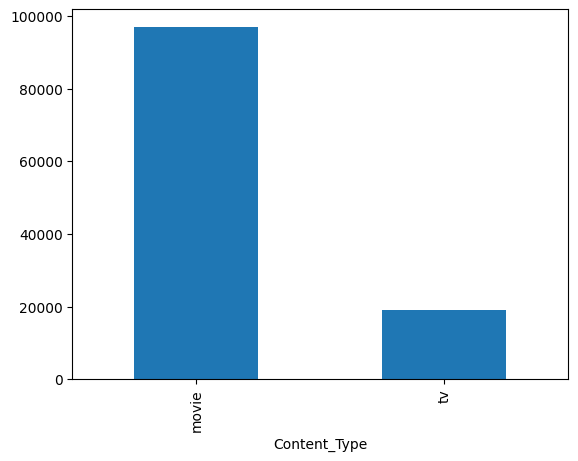

In [24]:
# Bar graph to compare Content_Type to Service_Name

streaming_clean["Content_Type"].value_counts().plot(kind='bar')

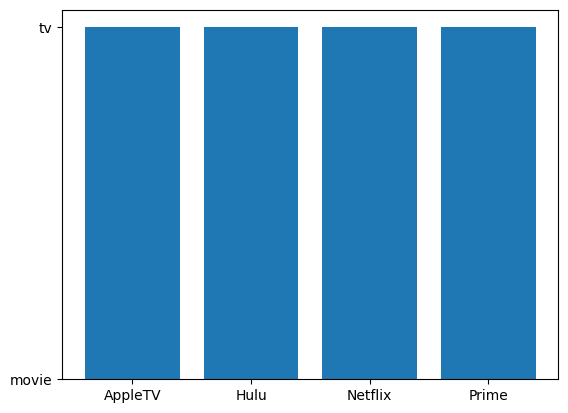

In [25]:
x = streaming_clean["Service_Name"]
y = streaming_clean["Content_Type"]

plt.bar(x,y)
plt.show()

In [26]:
# streaming_clean["Service_Name"] = pd.Categorical(streaming_clean["Service_Name"])
# streaming_clean.groupby("Service_Name")["Content_Type"].plot(kind='bar')

In [ ]:
# streaming_clean.plot(x="Service_Name)

SyntaxError: unterminated string literal (detected at line 1) (3871770126.py, line 1)

In [ ]:
# grouped = streaming_clean.groupby(["Service_Name","Content_Type"]).sum().unstack()
# grouped.plot(kind='barh')
# plt.show()

In [ ]:
# data = streaming_clean["Combined_Genres","Service_Name"]


<Axes: xlabel='Service_Name', ylabel='count'>

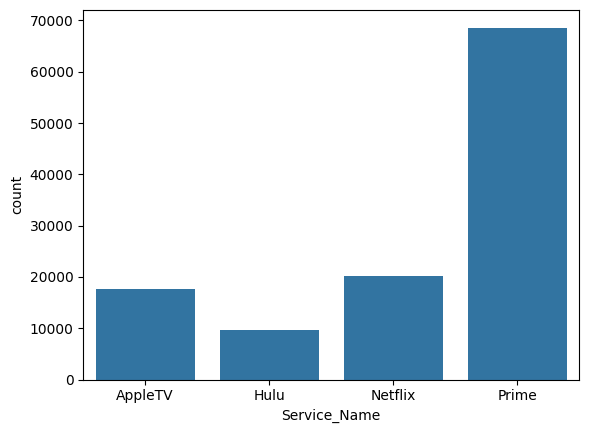

In [ ]:
# Plotting which streaming platform contains the most content
sn.countplot(streaming_clean, x="Service_Name")

<Axes: xlabel='Service_Name', ylabel='count'>

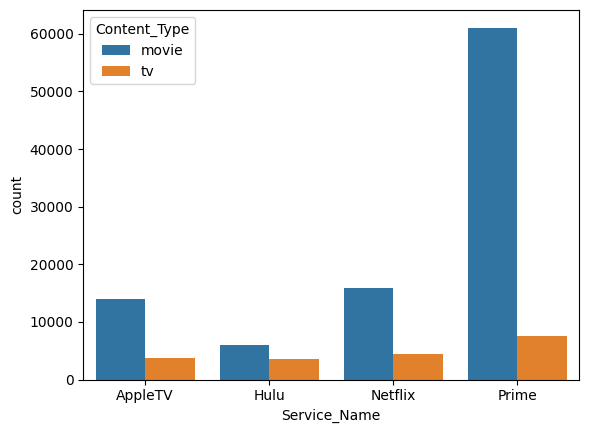

In [40]:
# Counts of the content type by streaming sesrvice
sn.countplot(streaming_clean,x="Service_Name", hue="Content_Type")

In [ ]:
# Counts of the content type by streaming sesrvice
# sn.countplot(streaming_clean,x="Service_Name", hue="Content_Type",palette=)